### Import libraries

- In the cell_data_analysis folder, data from the cells is extracted. Keep in mind that it can be complicated if they are not clearly visible.
- Here are the videos of your university to analyze: https://www.nanolive.ch/publication-biolab-universidad-de-la-laguna/ and https://cloud.iac.es/index.php/s/df5ZcfiAKFiPdAx
- The videos are in the folder "ata/240319_SW1573_Control_OLL452_OLL519_20uM_extracted_data
- They don't move much, so the object_tracking_from_scratch_source_cede code may suffice (download the code from here as I can't upload it because it's too heavy).
- Here is the code for cell detection: https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-020-03635-x

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

import seaborn as sns
from  datetime import datetime
from scipy.stats import ttest_ind
import os
%matplotlib inline

metrics = [1,2,3,4,5,6,7,8,9,10,13,15,16,19,20]

## Preliminary analysis of the data
we observe the structure of the original data (we take the first file as a sample)

In [2]:
file = f'data/original/Cell metrics_{metrics[0]} copy.csv'
df = pd.read_csv(file)
df

,Well,Cycle,Time,Cell Index,Cell area [um^2],Cell area [%],Cell perimeter [um],Cell form factor,Cell extent,Cell compactness,Cell eccentricity,Mean RI,Average dry mass density [pg / um^3],Dry mass [pg],Cell granularity
0,A1,1,00:00:20,1,471.48,0.776572,275.3940,0.078120,0.425646,12.80080,0.735266,1.34773,0.088648,133.747,5.86423
1,A1,1,00:00:20,2,408.56,0.672937,139.5090,0.263790,0.525547,3.79089,0.847883,1.34878,0.093876,122.733,7.12153
2,A1,1,00:00:20,3,737.20,1.214240,354.5060,0.073714,0.398504,13.56600,0.910670,1.34362,0.068090,160.628,9.07188
3,A1,1,00:00:20,4,495.96,0.816893,166.9360,0.223645,0.403220,4.47138,0.925866,1.34592,0.079605,126.339,6.13479
4,A1,1,00:00:20,5,483.96,0.797128,169.2730,0.212248,0.616196,4.71146,0.779687,1.34906,0.095314,147.609,7.78636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40589,B2,400,19:58:42,10,278.92,0.459408,83.8063,0.499041,0.690533,2.00384,0.478492,1.37901,0.245073,218.738,7.51191
40590,B2,400,19:58:42,11,457.08,0.752854,110.9060,0.466975,0.624426,2.14144,0.677771,1.35923,0.146156,213.776,4.54448
40591,B2,400,19:58:42,12,336.36,0.554017,103.1270,0.397437,0.619584,2.51612,0.400319,1.37027,0.201356,216.730,6.42875
40592,B2,400,19:58:42,13,324.28,0.534120,92.8264,0.472919,0.619328,2.11453,0.501096,1.36710,0.185498,192.490,5.45029


Description of the columns

![title](documentos/parametros.png)

Check the size of files:

In [3]:
for metric in metrics:
    # load the file
    file = f'data/original/Cell metrics_{metric} copy.csv'
    df = pd.read_csv(file)
    
    #check if there is NaNs in the data
    # and if there is NaNs print how many
    if df.isnull().values.any():
        print(f'File {metric:.2d} has {df.isnull().sum()} NaNs out of {len(df)}: {df.shape}')
    else:
        print(f'File {metric:02d} has not NaNs. Columns: {df.shape[1]:02d} Rows: {df.shape[0]:,}')

# empty the variable to free memory
df = None

# XXX: Sabemos si el archivo 8 y 9 son los mismos?

File 01 has not NaNs. Columns: 15 Rows: 40,594
File 02 has not NaNs. Columns: 15 Rows: 68,455
File 03 has not NaNs. Columns: 15 Rows: 18,081
File 04 has not NaNs. Columns: 15 Rows: 56,657
File 05 has not NaNs. Columns: 15 Rows: 72,667
File 06 has not NaNs. Columns: 15 Rows: 77,234
File 07 has not NaNs. Columns: 15 Rows: 60,380
File 08 has not NaNs. Columns: 15 Rows: 136,958
File 09 has not NaNs. Columns: 15 Rows: 136,958
File 10 has not NaNs. Columns: 15 Rows: 42,306
File 13 has not NaNs. Columns: 15 Rows: 54,173
File 15 has not NaNs. Columns: 15 Rows: 26,841
File 16 has not NaNs. Columns: 15 Rows: 60,004
File 19 has not NaNs. Columns: 15 Rows: 95,709
File 20 has not NaNs. Columns: 15 Rows: 98,552


import the table with the mapping of each compound


- Antes me daba error pero para poder ver las gráficas bien he supuesto que estan mal el 13 y 15 y falta control en la 20

- pone ControlSW en metrica 5, y hay vacios en la tabla (ver si es porque no estan los experimentos), he puesto Control, pero confirmar bien con ellos, tipos en Vinblastina y Vimblastina

In [4]:
df_compounds = pd.read_excel('data/original/Nombre de los productos.xlsx',header=0, names=["Experimento","A1","A2","B1","B2"])
df_compounds

,Experimento,A1,A2,B1,B2
0,1,Control,Taxol,Vimblastina,Colchicina
1,2,Control,Cisplatino,DTA100,NaN
2,3,Control,5-fluouracilo,Nocodazol,etoposido
3,4,Control,Control,Taxol,Vimblastina
4,5,Control,Tamoxifeno,Rapamycin,cloroquine
5,6,Control,Control,Rapamycin,cloroquine
6,7,Vimblastina,Colchicina,DTA100,Doxorubicina
7,8,Etoposido,DTA100,Colchicina,Taxol
8,9,Control,5-fluouracilo,Vimblastina,Tamoxifeno
9,10,Doxorubicina,DTA100,Control,Tamoxifeno


13-14 are experinental compounds

we see how many compounds there are and how many times they have been analyzed.

In [5]:
# create a list with all the compounds in all the experiments
all_compounds = [compound for row in df_compounds[['A1','A2','B1','B2']].values for compound in row]
# select only one repetition of each compound (remove duplicates)
unique_compounds = list(set(all_compounds))
# remove the NaNs (for the runs with less than 4 compounds)
unique_compounds.remove(np.nan)
# sort the list
unique_compounds.sort()
# print the list with the number of times each compound appears
for compound in unique_compounds:
    print(f"{compound:<15} compound has been tested {all_compounds.count(compound):02d} times in the experiments")

5-fluouracilo   compound has been tested 02 times in the experiments
ABL             compound has been tested 01 times in the experiments
BEL             compound has been tested 01 times in the experiments
Cisplatino      compound has been tested 01 times in the experiments
Colchicina      compound has been tested 05 times in the experiments
Control         compound has been tested 15 times in the experiments
DTA100          compound has been tested 04 times in the experiments
Doxorubicina    compound has been tested 02 times in the experiments
Etoposido       compound has been tested 01 times in the experiments
LSL             compound has been tested 01 times in the experiments
MOA             compound has been tested 01 times in the experiments
Nocodazol       compound has been tested 01 times in the experiments
OLL461          compound has been tested 01 times in the experiments
OLL465          compound has been tested 01 times in the experiments
Rapamycin       compound has been 

Now with the clean data we see that all have the same column names

In [6]:
# Check that all have the same columns

for metric_j in metrics:
    # Load one of the files
    df_metric_j = pd.read_csv(f'data/metrics_{metric_j}.csv')
    # and compare it with the rest
    for metric_i in metrics:
        # load one file
        df_metric_i = pd.read_csv(f'data/metrics_{metric_i}.csv')
        # compute the intersection of the sets of columns of the two files
        columns_difference = (set(df_metric_i.columns)-set(df_metric_j.columns)) | (set(df_metric_j.columns)-set(df_metric_i.columns))
        # if there are columns that are different print them
        if len(columns_difference):
            print(f"Metric {metric_i} has {columns_difference} columns than are differente from Metric {metric_j}")
    df_metric_i = None
    print(f"All okey between {metric_j:02d} and the rest")

# empty the variable to free memory
df_metric_j = None

All okey between 01 and the rest
All okey between 02 and the rest
All okey between 03 and the rest
All okey between 04 and the rest
All okey between 05 and the rest
All okey between 06 and the rest
All okey between 07 and the rest
All okey between 08 and the rest
All okey between 09 and the rest
All okey between 10 and the rest
All okey between 13 and the rest
All okey between 15 and the rest
All okey between 16 and the rest
All okey between 19 and the rest
All okey between 20 and the rest


If we want to rename some columns we can use the following code

In [7]:
# Rename the headers of the df to have the same in all the files

# file = f'data/original/Cell metrics_1 copy.csv'
# df = pd.read_csv(file)
# columns_names =  set(df.columns)

# for i in metrics:
    
#     new_file = f'data/metrics_{i}.csv'
#     old_file = f'data/original/Cell metrics_{i} copy.csv'
#     if os.path.exists(new_file):
#         df_old = pd.read_csv(new_file)
#     else:
#         df_old = pd.read_csv(old_file)

#     old_header = "Cell extent"

#     new_file = f'data/metrics_{i}.csv'    
#     new_header = "Extent"
    
#     if old_header in df_old.columns:
#         df_old.rename(columns={old_header:new_header},inplace=True)
#         df_old.to_csv(new_file,index=False)

In [8]:
# Move the rest of the df
# for i in metrics:
#     new_file = f'data/metrics_{i}.csv'
#     old_file = f'data/original/Cell metrics_{i} copy.csv'
#     if not os.path.exists(new_file):
#         df_old = pd.read_csv(old_file)
#         df_old.to_csv(new_file,index=False)

some experiments have 300 cicles and others 400

In [9]:
for metric in metrics:
    # load the file
    file = f'data/metrics_{metric}.csv'
    df = pd.read_csv(file)
    
    print(f'File {file} has {df["Cycle"].max()} cycles {[str(well)+":"+str(len(df[df["Well"]==well]["Cycle"].unique())) for well in df["Well"].unique()]}')


File data/metrics_1.csv has 400 cycles ['A1:400', 'A2:400', 'B1:400', 'B2:400']
File data/metrics_2.csv has 400 cycles ['A1:400', 'A2:400', 'B1:400']
File data/metrics_3.csv has 400 cycles ['A1:400', 'A2:400', 'B1:400', 'B2:400']
File data/metrics_4.csv has 400 cycles ['A1:400', 'A2:400', 'B1:400', 'B2:400']
File data/metrics_5.csv has 400 cycles ['A1:400', 'A2:400', 'B1:400', 'B2:400']
File data/metrics_6.csv has 400 cycles ['A1:400', 'A2:400', 'B1:400', 'B2:400']
File data/metrics_7.csv has 400 cycles ['A1:400', 'A2:400', 'B1:323', 'B2:400']
File data/metrics_8.csv has 400 cycles ['A1:400', 'A2:400', 'B1:400', 'B2:400']
File data/metrics_9.csv has 400 cycles ['A1:400', 'A2:400', 'B1:400', 'B2:400']
File data/metrics_10.csv has 400 cycles ['A1:400', 'A2:400', 'B1:400', 'B2:400']
File data/metrics_13.csv has 400 cycles ['A1:400', 'A2:400', 'B1:400', 'B2:400']
File data/metrics_15.csv has 300 cycles ['A1:300', 'A2:300', 'B2:300']
File data/metrics_16.csv has 400 cycles ['A1:400', 'A2:40

Check the name of each compound in the experiments

In [10]:

for metric in metrics:
    # load the file with the data
    file = f'data/metrics_{metric}.csv'
    df = pd.read_csv(file)
    # load the file with the compounds
    df_metric = df_compounds[['A1','A2','B1','B2']][df_compounds['Experimento']==metric]
    # get the names of the compounds
    names = df_metric.values
    # remove the NaNs
    names = names[~pd.isnull(df_metric)]
    # get the wells of the data
    wells = df["Well"].unique()
    
    if len(wells) != len(names):
        print(f"\nERROR, Well and Names have different lengths, please check the file {file}")
        print("-"*40)
        print(wells, names)
        print(df_metric)
        print("-"*40)

    
    else:
        #check how many compounds are in the file
        print(f'File {file} has {len(wells)} compounds and {len(names)} uniques:',[f"{x} = {name}" for x ,name in zip(wells,names)])

File data/metrics_1.csv has 4 compounds and 4 uniques: ['A1 = Control', 'A2 = Taxol', 'B1 = Vimblastina', 'B2 = Colchicina']
File data/metrics_2.csv has 3 compounds and 3 uniques: ['A1 = Control', 'A2 = Cisplatino', 'B1 = DTA100']
File data/metrics_3.csv has 4 compounds and 4 uniques: ['A1 = Control', 'A2 = 5-fluouracilo', 'B1 = Nocodazol', 'B2 = etoposido']
File data/metrics_4.csv has 4 compounds and 4 uniques: ['A1 = Control', 'A2 = Control', 'B1 = Taxol', 'B2 = Vimblastina']
File data/metrics_5.csv has 4 compounds and 4 uniques: ['A1 = Control', 'A2 = Tamoxifeno', 'B1 = Rapamycin', 'B2 = cloroquine']
File data/metrics_6.csv has 4 compounds and 4 uniques: ['A1 = Control', 'A2 = Control', 'B1 = Rapamycin', 'B2 = cloroquine']
File data/metrics_7.csv has 4 compounds and 4 uniques: ['A1 = Vimblastina', 'A2 = Colchicina', 'B1 = DTA100', 'B2 = Doxorubicina']
File data/metrics_8.csv has 4 compounds and 4 uniques: ['A1 = Etoposido', 'A2 = DTA100', 'B1 = Colchicina', 'B2 = Taxol']
File data/m

XXX FICHERO 13 15 y 20 tienen problemas (se ha cambiado nombres de 13 por 15 y añadido control al 20)


see the size of the observations of each experiment

In [11]:
for metric in metrics:
    # load the file
    file = f'data/metrics_{metric}.csv'
    df = pd.read_csv(file)

    list_string = [f"{well}:{df[df['Well']==well].shape[0]:,}" for well in df["Well"].unique()]
    print(f'File {metric:02d} has {len(df["Cycle"].unique())} cycles {list_string}')

File 01 has 400 cycles ['A1:16,740', 'A2:7,493', 'B1:10,140', 'B2:6,221']
File 02 has 400 cycles ['A1:26,872', 'A2:19,577', 'B1:22,006']
File 03 has 400 cycles ['A1:4,994', 'A2:8,572', 'B1:1,999', 'B2:2,516']
File 04 has 400 cycles ['A1:17,683', 'A2:24,189', 'B1:4,429', 'B2:10,356']
File 05 has 400 cycles ['A1:12,788', 'A2:18,443', 'B1:19,060', 'B2:22,376']
File 06 has 400 cycles ['A1:17,160', 'A2:5,547', 'B1:27,165', 'B2:27,362']
File 07 has 400 cycles ['A1:13,794', 'A2:13,193', 'B1:11,362', 'B2:22,031']
File 08 has 400 cycles ['A1:59,405', 'A2:4,234', 'B1:30,762', 'B2:42,557']
File 09 has 400 cycles ['A1:59,405', 'A2:4,234', 'B1:30,762', 'B2:42,557']
File 10 has 400 cycles ['A1:16,513', 'A2:8,717', 'B1:8,285', 'B2:8,791']
File 13 has 400 cycles ['A1:15,775', 'A2:18,207', 'B1:7,244', 'B2:12,947']
File 15 has 300 cycles ['A1:12,928', 'A2:9,133', 'B2:4,780']
File 16 has 400 cycles ['A1:15,716', 'A2:21,393', 'B1:11,483', 'B2:11,412']
File 19 has 300 cycles ['A1:19,318', 'A2:16,675', 'B1:

Check how many cells are in each picture, to know how much data we could obtain if we would use the evoltion of each cell

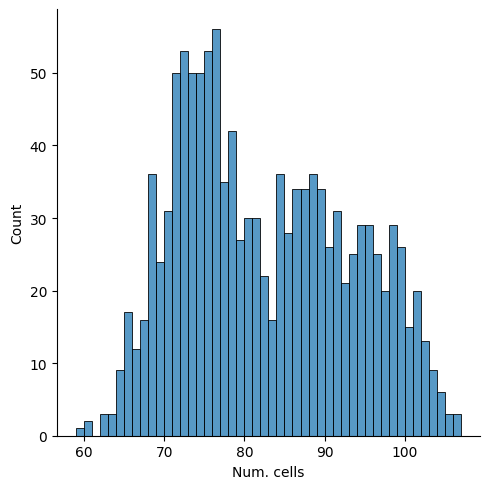

,Well,Cycle,Num. cells
0,A1,1,78
1,A1,2,76
2,A1,3,75
3,A1,4,74
4,A1,5,74


In [12]:
for metric in metrics:
   # load the file
    file = f'data/metrics_{metric}.csv'
    df = pd.read_csv(file)  
    list_info = []
    for well in df['Well'].unique():
       for cycle in df['Cycle'].unique():
         # add to the list the well, the cycle, and the number of cells in that cycle (shape of the df where the well and cycle are the same) 
          list_info.append([well, cycle, df[(df['Well']==well) & (df['Cycle']==cycle)].shape[0]])

# create a dataframe with the list and plot the dataframe with a histogram
df_distribution = pd.DataFrame(list_info,columns=['Well',"Cycle","Num. cells"])
sns.displot(df_distribution, x="Num. cells",binwidth=1)
plt.show()
df_distribution.head()


XXX Comartir este gráfico con ellos para que vean si tiene sentido y hay esas celulas. Por que en los videos no vemos tantisimas celulas.

Now we see how the number of objects increases with time, this means that as time progresses the number of cells increases.

In [13]:
df.head()

,Well,Cycle,Time,Object Index,Area [um^2],Area [%],Perimeter [um],Form factor,Extent,Compactness,Eccentricity,Characteristic RI,Characteristic dry mass density [pg / um^3],Dry mass [pg],Granularity
0,A1,1,00:06:50,1,237.88,0.391811,113.3020,0.232858,0.589279,4.29446,0.929057,1.34519,0.075942,57.8085,7.15214
1,A1,1,00:06:50,2,223.64,0.368356,89.1352,0.353721,0.529451,2.82709,0.737494,1.34521,0.076034,54.4135,6.15679
2,A1,1,00:06:50,3,382.36,0.629783,127.7900,0.294232,0.493368,3.39868,0.841341,1.34441,0.072051,88.1583,5.97877
3,A1,1,00:06:50,4,473.88,0.780525,226.8360,0.115732,0.572872,8.64066,0.912722,1.34552,0.077611,117.6910,5.17537
4,A1,1,00:06:50,5,333.68,0.549603,130.1780,0.247437,0.515447,4.04144,0.623461,1.34801,0.090045,96.1480,4.82105


In [14]:
# regresion cycle vs number of cells
list_x = []
list_y = []

for metric in metrics:
    file = f'data/metrics_{metric}.csv'
    df = pd.read_csv(file)
    for well in df['Well'].unique():
        for cycle in df[df['Well']==well]['Cycle'].unique():
            list_y.append(df[(df['Well']==well) & (df['Cycle']==cycle)].shape[0])
            list_x.append(cycle)

Cuanta la evolución de las celudlas en cada ciclo de todos los experimentos


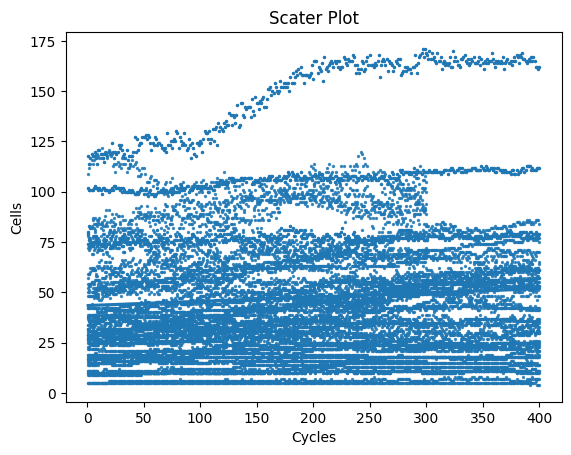

In [15]:
# Creating the scatter plot
sns.regplot(x=list_x, y=list_y,marker='o',scatter_kws={'s':2},scatter=True)

# Adding labels and title
plt.xlabel('Cycles')
plt.ylabel('Cells')
plt.title('Scater Plot')

# Displaying the plot
plt.show()

En el scatter plot vemos como las hay una gran variación en el numbero de celulas.

XXX Mostrales esto a ellos para que vean los datos que estamos teniendo y ver si tiene sentido. Que las celulas aumenten de 120 a 175.

Hacemos una grafica eje X cuantas celculas tiene a inici, eje Y cuantas celculas tiene alfinal y una linea de 45 que indique la no varaicion del numero de celulas.

In [12]:
# regresion cycle vs number of cells
list_x = []
list_y = []

for metric in metrics:
    file = f'data/metrics_{metric}.csv'
    df = pd.read_csv(file)
    for well in df['Well'].unique():
        min_cylce = min(df[df['Well']==well]['Cycle'].unique())
        max_cylce = max(df[df['Well']==well]['Cycle'].unique())
        list_y.append(df[(df['Well']==well) & (df['Cycle']==max_cylce)].shape[0])
        list_x.append(df[(df['Well']==well) & (df['Cycle']==min_cylce)].shape[0])

print(len(list_x),len(list_y))

58 58


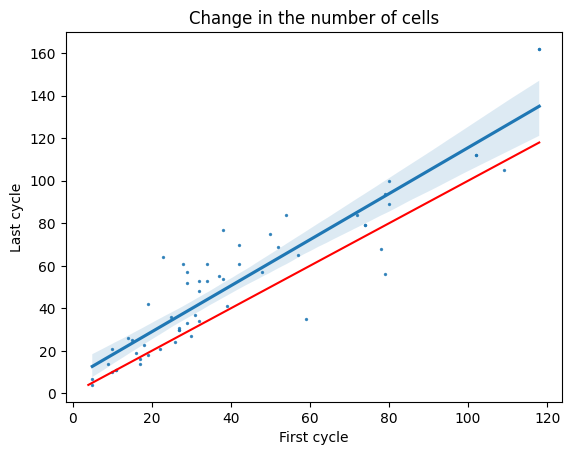

In [16]:
# Creating the scatter plot 
sns.regplot(x=list_x, y=list_y,marker='o',scatter_kws={'s':2},scatter=True)
# plot a 45 degree red line
max_num_of_cells = max(list_x)
min_num_of_cells = min(min(list_y),min(list_x))
plt.plot([min_num_of_cells,max_num_of_cells],[min_num_of_cells,max_num_of_cells],'r')
plt.xlabel('First cycle')
plt.ylabel('Last cycle')
plt.title('Change in the number of cells')
plt.show()


Ahora vemos si los saltos en el tiempo son realmente tres minutos o hay de todo. 

XXX Mostrales tambien esto

In [16]:
list_info = []

for metric in metrics:
    file = f'data/metrics_{metric}.csv'
    df = pd.read_csv(file)
    for well in df['Well'].unique():
        df_j = df[df['Well']==well]
        list_times = [datetime.strptime(x,"%H:%M:%S") for x in df_j['Time']]
        list_of_seconds = [(x - datetime(1900,1,1)).total_seconds() for x in list_times]
        jumps = [x1-x2 for x1,x2 in zip(list_of_seconds[1:],list_of_seconds[:-1]) if x1-x2 != 0]
        list_info = list_info + jumps


Most of the jumps are every 3 minutes (180 seconds)

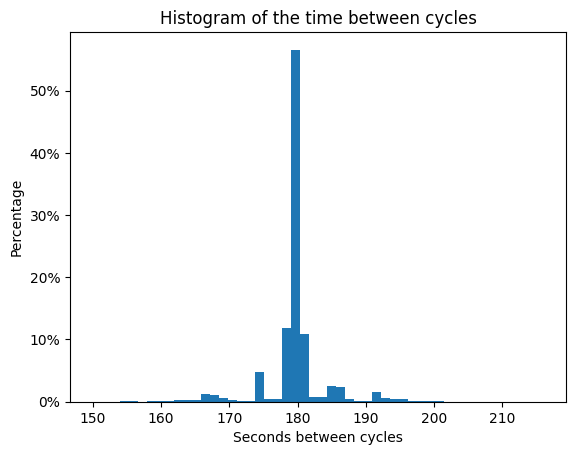

In [17]:
# show the histogram
plt.hist(list_info, bins=50, weights=[1. / len(list_info)] * len(list_info))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title("Histogram of the time between cycles")
plt.ylabel("Percentage")
plt.xlabel("Seconds between cycles")
plt.show()

## Creamos un solo csv 

1) Importamos el nombre de los reactivos y los reemplazamos en cada df

In [4]:
df_compounds = pd.read_excel('data/original/Nombre de los productos.xlsx',header=0, names=["Experimento","A1","A2","B1","B2"])
df_compounds.dropna(subset=['Experimento'], inplace=True)
df_compounds

,Experimento,A1,A2,B1,B2
0,1,Control,Taxol,Vimblastina,Colchicina
1,2,Control,Cisplatino,DTA100,NaN
2,3,Control,5-fluouracilo,Nocodazol,etoposido
3,4,Control,Control,Taxol,Vimblastina
4,5,Control,Tamoxifeno,Rapamycin,cloroquine
5,6,Control,Control,Rapamycin,cloroquine
6,7,Vimblastina,Colchicina,DTA100,Doxorubicina
7,8,Etoposido,DTA100,Colchicina,Taxol
8,9,Control,5-fluouracilo,Vimblastina,Tamoxifeno
9,10,Doxorubicina,DTA100,Control,Tamoxifeno


we now insert the category of the compound in the data to do the clasiification


<img src="documentos/classification.png" width="400" alt="title">



In [5]:
# so the supergroups are
target_dict = { 
               'Taxol': 'Microtubule',
               'Colchicina': 'Microtubule',
               'Vimblastina': 'Microtubule',
               'DTA100': 'Microtubule',
               'Nocodazol': 'Microtubule',

               'cloroquine': 'Autophagy',
               'Rapamycin': 'Autophagy',
               'Tamoxifeno': 'Autophagy',

                'Cisplatino': 'DNA',
                '5-fluouracilo': 'DNA',
                'etoposido': 'DNA',
                'Control': 'Control',
                'NaN': 'Unknown'
                }

# set the default target as unknown if the compound is not in the dictionary

def map_target(x):
    if x in target_dict:
        return target_dict[x]
    else:
        return 'Unknown'

In [6]:
# Make a classification of the compounds in the df_compounds
df_compounds['A1c'] = df_compounds['A1'].map(map_target)
df_compounds['A2c'] = df_compounds['A2'].map(map_target)
df_compounds['B1c'] = df_compounds['B1'].map(map_target)
df_compounds['B2c'] = df_compounds['B2'].map(map_target)

df_compounds

,Experimento,A1,A2,B1,B2,A1c,A2c,B1c,B2c
0,1,Control,Taxol,Vimblastina,Colchicina,Control,Microtubule,Microtubule,Microtubule
1,2,Control,Cisplatino,DTA100,NaN,Control,DNA,Microtubule,Unknown
2,3,Control,5-fluouracilo,Nocodazol,etoposido,Control,DNA,Microtubule,DNA
3,4,Control,Control,Taxol,Vimblastina,Control,Control,Microtubule,Microtubule
4,5,Control,Tamoxifeno,Rapamycin,cloroquine,Control,Autophagy,Autophagy,Autophagy
5,6,Control,Control,Rapamycin,cloroquine,Control,Control,Autophagy,Autophagy
6,7,Vimblastina,Colchicina,DTA100,Doxorubicina,Microtubule,Microtubule,Microtubule,Unknown
7,8,Etoposido,DTA100,Colchicina,Taxol,Unknown,Microtubule,Microtubule,Microtubule
8,9,Control,5-fluouracilo,Vimblastina,Tamoxifeno,Control,DNA,Microtubule,Autophagy
9,10,Doxorubicina,DTA100,Control,Tamoxifeno,Unknown,Microtubule,Control,Autophagy


2) creamos una nueva columna para indicar el experimento y mapeamos el indice del compusto por el compuesto 
3) Concatenmos los df

In [7]:
list_df = []
for metric in metrics:
    df = pd.read_csv(f'data/metrics_{metric}.csv')
    df['Metric'] = metric
    df['Wellc'] = df['Well'].map(lambda x: x+'c')
    dict_well = df_compounds[df_compounds['Experimento']==metric].to_dict('records')[0]
    df['Well Compounds'] = df['Well'].map(dict_well)
    df['Well Target'] = df['Wellc'].map(dict_well)
    list_df.append(df)

In [8]:
df_all = pd.concat(list_df,axis=0)
print(df_all.shape)
df_all

(1045569, 19)


,Well,Cycle,Time,Object Index,Area [um^2],Area [%],Perimeter [um],Form factor,Extent,Compactness,Eccentricity,Characteristic RI,Characteristic dry mass density [pg / um^3],Dry mass [pg],Granularity,Metric,Wellc,Well Compounds,Well Target
0,A1,1,00:00:20,1,471.48,0.776572,275.3940,0.078120,0.425646,12.80080,0.735266,1.34773,0.088648,133.7470,5.86423,1,A1c,Control,Control
1,A1,1,00:00:20,2,408.56,0.672937,139.5090,0.263790,0.525547,3.79089,0.847883,1.34878,0.093876,122.7330,7.12153,1,A1c,Control,Control
2,A1,1,00:00:20,3,737.20,1.214240,354.5060,0.073714,0.398504,13.56600,0.910670,1.34362,0.068090,160.6280,9.07188,1,A1c,Control,Control
3,A1,1,00:00:20,4,495.96,0.816893,166.9360,0.223645,0.403220,4.47138,0.925866,1.34592,0.079605,126.3390,6.13479,1,A1c,Control,Control
4,A1,1,00:00:20,5,483.96,0.797128,169.2730,0.212248,0.616196,4.71146,0.779687,1.34906,0.095314,147.6090,7.78636,1,A1c,Control,Control
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98547,B2,300,15:05:29,85,233.32,0.384300,93.0276,0.338796,0.493611,2.95163,0.859475,1.34889,0.094442,70.5127,7.83123,20,B2c,BEL,Unknown
98548,B2,300,15:05:29,86,216.52,0.356629,64.0441,0.663361,0.665478,1.50747,0.639039,1.35986,0.149281,103.4310,7.49048,20,B2c,BEL,Unknown
98549,B2,300,15:05:29,87,177.48,0.292326,72.0144,0.430051,0.584585,2.32530,0.910359,1.36513,0.175652,99.7590,4.96674,20,B2c,BEL,Unknown
98550,B2,300,15:05:29,88,262.64,0.432593,87.9281,0.426889,0.667276,2.34253,0.737718,1.34972,0.098584,82.8548,8.61766,20,B2c,BEL,Unknown


In [9]:
maping_target = {target: i for i,target in enumerate(df_all['Well Target'].unique())}
df_all['Target'] = df_all['Well Target'].map(maping_target)
maping_target

{'Control': 0, 'Microtubule': 1, 'DNA': 2, 'Autophagy': 3, 'Unknown': 4}

In [10]:
df_all

,Well,Cycle,Time,Object Index,Area [um^2],Area [%],Perimeter [um],Form factor,Extent,Compactness,Eccentricity,Characteristic RI,Characteristic dry mass density [pg / um^3],Dry mass [pg],Granularity,Metric,Wellc,Well Compounds,Well Target,Target
0,A1,1,00:00:20,1,471.48,0.776572,275.3940,0.078120,0.425646,12.80080,0.735266,1.34773,0.088648,133.7470,5.86423,1,A1c,Control,Control,0
1,A1,1,00:00:20,2,408.56,0.672937,139.5090,0.263790,0.525547,3.79089,0.847883,1.34878,0.093876,122.7330,7.12153,1,A1c,Control,Control,0
2,A1,1,00:00:20,3,737.20,1.214240,354.5060,0.073714,0.398504,13.56600,0.910670,1.34362,0.068090,160.6280,9.07188,1,A1c,Control,Control,0
3,A1,1,00:00:20,4,495.96,0.816893,166.9360,0.223645,0.403220,4.47138,0.925866,1.34592,0.079605,126.3390,6.13479,1,A1c,Control,Control,0
4,A1,1,00:00:20,5,483.96,0.797128,169.2730,0.212248,0.616196,4.71146,0.779687,1.34906,0.095314,147.6090,7.78636,1,A1c,Control,Control,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98547,B2,300,15:05:29,85,233.32,0.384300,93.0276,0.338796,0.493611,2.95163,0.859475,1.34889,0.094442,70.5127,7.83123,20,B2c,BEL,Unknown,4
98548,B2,300,15:05:29,86,216.52,0.356629,64.0441,0.663361,0.665478,1.50747,0.639039,1.35986,0.149281,103.4310,7.49048,20,B2c,BEL,Unknown,4
98549,B2,300,15:05:29,87,177.48,0.292326,72.0144,0.430051,0.584585,2.32530,0.910359,1.36513,0.175652,99.7590,4.96674,20,B2c,BEL,Unknown,4
98550,B2,300,15:05:29,88,262.64,0.432593,87.9281,0.426889,0.667276,2.34253,0.737718,1.34972,0.098584,82.8548,8.61766,20,B2c,BEL,Unknown,4


4) Guardamos el df unico. Con esto ya podmos emepezar a entrenar los modelos

In [11]:
path = 'data/all_metrics.csv'
df_all.to_csv(path)